In [211]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns

In [212]:
url1 = "https://raw.githubusercontent.com/ayedaemon/RuckSack-Python/master/log_analysis/access_log"
url2 = "https://raw.githubusercontent.com/ayedaemon/RuckSack-Python/master/log_analysis/access_log2"
url3 = "https://raw.githubusercontent.com/robert456456456456/Web_server_log_parser/master/devops.log"
url_all=[url1,url2,url3]

In [213]:
url =  "https://raw.githubusercontent.com/robert456456456456/Web_server_log_parser/master/devops.log"

In [214]:
logs = []
for j,urls in enumerate(url_all):
    content = requests.get(urls)
    print(j)
    data = (content.content.decode('UTF-8'))
    if j==2:
        data = data.split("\r\n")
    else:
        data = data.split("\n")
    data.pop()
    logs.append(data)
    #del data[906]

0
1
2


In [215]:
final_log = [item for sublist in logs for item in sublist]

In [216]:
len(final_log)

3346

In [30]:
def filter(l):
    ip = l.split(" - - [",1)[0]
    l = l.split(" - - [",1)[1]
    time = l.split(" ",1)[0]
    l = l.split(" ",1)[1]
    offset = l.split("] ",1)[0]
    l = l.split('] "',1)[1]
    try:
        action = l.split(' HTTP/1.')[0]
        l = l.split(' HTTP/1.')[1]
        l = l.split('" ')[1]
    except:
        action = l.split('" ')[0]
        l = l.split('" ')[1]
    retcode = l.split(" ",1)[0]
    size = l.split(" ",1)[1]
    return [ip,time,offset,action,retcode,size]

In [31]:
cleaned_data = []
for i,j in enumerate(data):
    cleaned_data.append(filter(j))

In [217]:
import re

In [218]:
def extract_ips_website(data):
    #regexp=r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
    ips = []
    website = []
    regexp="(.*?)- -"
    re2='(GET|POST|OPTIONS|HEAD)(.*?)(HTTP)'
    re3='(GET|POST|OPTIONS|HEAD)(.*?)(")'
    re4='(")(.*?)(")'
    for j,i in enumerate(data):
        ips.append(re.findall(regexp,i))
        try:
            website.append(re.findall(re2,i)[0][1])
        except:
            try:
                website.append(re.findall(re3,i)[0][1])
            except:
                w = (re.findall(re4,i)[0][1])
                if w == "-":
                    website.append("none")
    return ips,website

def extract_time(data):
    time = []
    regexp='\[(.*?)\]'
    for j,i in enumerate(data):
        time.append(re.findall(regexp,i)[0])
    return time
def get_location(ip):
    response = requests.get("https://geolocation-db.com/json/{}&position=true".format(ip)).json()
    return response['country_name']

In [252]:
e_ip,e_web = extract_ips_website(final_log)
times = extract_time(final_log)
e_ip = [i[0].strip() for i in e_ip]

## Getting geo location

In [220]:
def get_location(ip):
    response = requests.get("https://geolocation-db.com/json/{}&position=true".format(ip)).json()
    return response['country_name']

In [221]:
import time
start = time.time()
country = []
present = []
generated = []
for j,i in enumerate(e_ip):
    if i not in present:
        present.append(i)
        location = get_location(i)
        generated.append([i,location])
        country.append(location)
    else:
        for k in generated:
            if k[0]==i:
                country.append(location)
print("time taken: ",time.time()-start)

time taken:  123.74594354629517


In [222]:
co = country.copy()

In [223]:
for i,j in enumerate(co):
    if j == "Not found":
        co[i] = "Unknown"
        #ci[i] = "Unknown"
        #s[i] = "Unknown"

In [253]:
df = pd.DataFrame(data=e_ip,columns=["ip"])
df['website'] = e_web
df['time'] = times
df['Country'] = co
df.head(7)

,ip,website,time,Country
0,127.0.0.1,/,15/Jan/2021:08:54:07 +0000,Unknown
1,127.0.0.1,/cgi-bin/weakform.py,15/Jan/2021:08:55:23 +0000,Unknown
2,127.0.0.1,/cgi-bin/weak_form.py,15/Jan/2021:09:01:38 +0000,Unknown
3,172.17.0.1,/,15/Jan/2021:09:02:14 +0000,Unknown
4,172.17.0.1,/noindex/common/css/bootstrap.min.css,15/Jan/2021:09:02:15 +0000,Unknown
5,172.17.0.1,/noindex/common/css/styles.css,15/Jan/2021:09:02:15 +0000,Unknown
6,172.17.0.1,/noindex/common/images/pb-centos.png,15/Jan/2021:09:02:15 +0000,Unknown


# Top 5 visited users

In [254]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

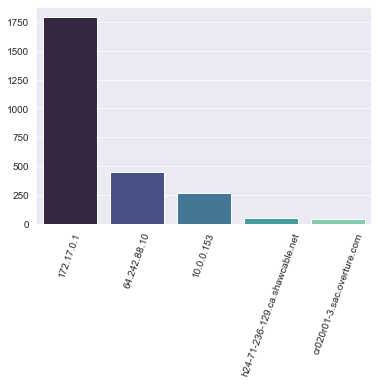

In [255]:
sns.barplot(df.ip.value_counts().index[:5],df.ip.value_counts().values[:5],palette="mako")
plt.xticks(rotation=70)

In [256]:
name = (df.ip.value_counts())

In [257]:
name.head(5)

172.17.0.1                         1792
64.242.88.10                        452
10.0.0.153                          270
h24-71-236-129.ca.shawcable.net      51
cr020r01-3.sac.overture.com          44
Name: ip, dtype: int64

# Top 5 visited pages

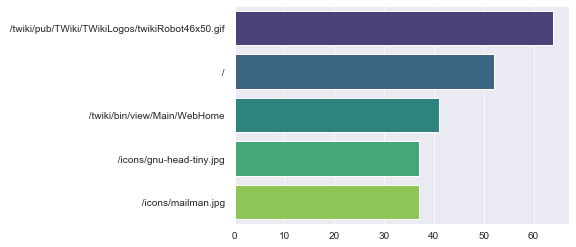

In [258]:
sns.barplot(df.website.value_counts().values[:5],df.website.value_counts().index[:5],palette="viridis")

In [259]:
page  = df.website.value_counts()

In [260]:
page.head(5)

 /twiki/pub/TWiki/TWikiLogos/twikiRobot46x50.gif     64
 /                                                   52
 /twiki/bin/view/Main/WebHome                        41
 /icons/gnu-head-tiny.jpg                            37
 /icons/mailman.jpg                                  37
Name: website, dtype: int64

# Least 5 visited pages

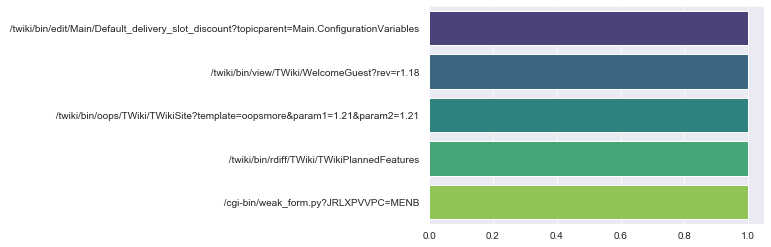

In [261]:
sns.barplot(df.website.value_counts().values[-5:],df.website.value_counts().index[-5:],palette="viridis")

In [262]:
page  = df.website.value_counts()
page.tail(5)

 /twiki/bin/edit/Main/Default_delivery_slot_discount?topicparent=Main.ConfigurationVariables     1
 /twiki/bin/view/TWiki/WelcomeGuest?rev=r1.18                                                    1
 /twiki/bin/oops/TWiki/TWikiSite?template=oopsmore&param1=1.21&param2=1.21                       1
 /twiki/bin/rdiff/TWiki/TWikiPlannedFeatures                                                     1
 /cgi-bin/weak_form.py?JRLXPVVPC=MENB                                                            1
Name: website, dtype: int64

# XSS attack finder

In [263]:
def XSS_finder(str_):
    flag = 0
    l1 = ['<','>','\\','`']
    l2 = ['/',')','(']
    for char in l1:
        aasci_encoding = '%'+hex(ord(char)).replace('0x','')
        if (char in str_) or (aasci_encoding in str_):
            flag = 1
            break
    if flag != 1:
        try:
            req_str = ''.join(str_.split('?')[1:])
            for char in l2:
                aasci_encoding = '%'+hex(ord(char)).replace('0x','')
                if (char in req_str) or (aasci_encoding in req_str):
                    flag = 1
                    break
        except:
            pass
    return bool(flag)

In [264]:
df['XSS_attack'] = df['website'].apply(XSS_finder)
df[df['XSS_attack']==True]

,ip,website,time,Country,XSS_attack
754,172.17.0.1,/cgi-bin/weak_form.py?fname=asdasd%3C%2Fp%3E%...,15/Jan/2021:10:05:35 +0000,Unknown,True
757,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:29:02 +0000,Unknown,True
758,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:04 +0000,Unknown,True
759,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:42 +0000,Unknown,True
760,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:57 +0000,Unknown,True
761,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:04 +0000,Unknown,True
762,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:24 +0000,Unknown,True
763,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:28 +0000,Unknown,True
764,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:34 +0000,Unknown,True
765,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:32:02 +0000,Unknown,True


In [265]:
df['XSS_attack'].value_counts()

False    3295
True       51
Name: XSS_attack, dtype: int64

In [266]:
df.head(5)

,ip,website,time,Country,XSS_attack
0,127.0.0.1,/,15/Jan/2021:08:54:07 +0000,Unknown,False
1,127.0.0.1,/cgi-bin/weakform.py,15/Jan/2021:08:55:23 +0000,Unknown,False
2,127.0.0.1,/cgi-bin/weak_form.py,15/Jan/2021:09:01:38 +0000,Unknown,False
3,172.17.0.1,/,15/Jan/2021:09:02:14 +0000,Unknown,False
4,172.17.0.1,/noindex/common/css/bootstrap.min.css,15/Jan/2021:09:02:15 +0000,Unknown,False


In [268]:
def html_to_df(urls, clean_empty = False , attrs = {}, helper = None):
    df_l = []
    for url in urls:
        html_content = requests.get(url).text
        soup = bs(html_content, "lxml")
        table = str(soup.find("table", attrs=attrs))
        df = pd.read_html(str(table))[0]
    
        if clean_empty :
            df = df.loc[:, ~df.isnull().all(axis = 0)]
        
        if helper:
            df = helper(df) 
        df_l.append(df)
    return pd.concat(df_l,ignore_index=True)

In [274]:
d = html_to_df(ur,clean_empty=True)

In [280]:
df

,ip,website,time,Country,XSS_attack,browser
0,127.0.0.1,/,15/Jan/2021:08:54:07,Unknown,False,curl/7.61.1
1,127.0.0.1,/cgi-bin/weakform.py,15/Jan/2021:08:55:23,Unknown,False,curl/7.61.1
2,127.0.0.1,/cgi-bin/weak_form.py,15/Jan/2021:09:01:38,Unknown,False,curl/7.61.1
3,172.17.0.1,/,15/Jan/2021:09:02:14,Unknown,False,Mozilla/5.0 (X11; Linux x86_64; rv:84.0) Gecko...
4,172.17.0.1,/noindex/common/css/bootstrap.min.css,15/Jan/2021:09:02:15,Unknown,False,Mozilla/5.0 (X11; Linux x86_64; rv:84.0) Gecko...
...,...,...,...,...,...,...
3341,10.0.0.153,/dccstats/stats-spam-ratio.1year.png,12/Mar/2004:12:23:41,United States,False,-
3342,10.0.0.153,/dccstats/stats-hashes.1year.png,12/Mar/2004:12:23:41,United States,False,-
3343,216.139.185.45,/mailman/listinfo/webber,12/Mar/2004:13:04:01,United States,False,-
3344,pd95f99f2.dip.t-dialin.net,/razor.html,12/Mar/2004:13:18:57,India,False,-


In [281]:
def OS_dict(browser_series):
    os = ['Windows','Linux','Android','Other']
    res_dict = {o:0 for o in os}
    for browser in browser_series:
        flag = 0
        for i in os[:-1]:
            if i in browser:
                res_dict[i]+=1
                flag = 1
                break
        if flag==0:
            res_dict['Other']+=1
    return res_dict

In [283]:
OS = OS_dict(df['browser'])

In [284]:
OS

{'Windows': 1369, 'Linux': 373, 'Android': 0, 'Other': 1604}

In [288]:
plt.style.use("seaborn")

In [290]:
plt.pie?

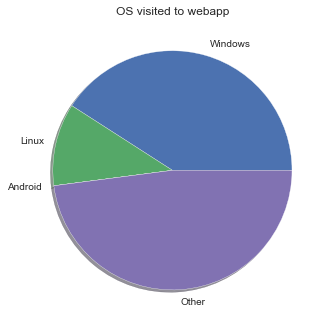

In [298]:
plt.pie( list(OS.values()), labels=list(OS.keys()),shadow=True)
plt.title("OS visited to webapp")
plt.show()

In [299]:
dt_series = pd.to_datetime(df['time'], format = '%d/%b/%Y:%H:%M:%S')

In [308]:
df.columns

Index(['ip', 'website', 'time', 'Country', 'XSS_attack', 'browser'], dtype='object')

In [315]:
dt_series[2]

Timestamp('2021-01-15 09:01:38')

In [331]:
import plotly.express as px
def plot_hit_vs_time(dt_series,title,xlabel,ylabel):
    fig = px.line( x=dt_series.unique(), y=dt_series.value_counts(sort = False))
    fig.update_layout(
        title=title,
         xaxis_title=xlabel,
        yaxis_title=ylabel)

    fig.show()

In [332]:
plot_hit_vs_time(df['time'],
                'Hit v/s time',
                'Time',
                'Hits')